In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from PIL import Image

from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

from keras.models import load_model

from google.colab.patches import cv2_imshow
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/lfw-deepfunneled/'

In [ ]:
def preprocess(img):
  clf = cv2.CascadeClassifier(cv2.data.haarcascades +'haarcascade_frontalface_default.xml')
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  
  gray = np.array(img, dtype='uint8')
  faces = clf.detectMultiScale(gray, 1.3, 3)
  
  cropped_img = None
  for (x, y, w, h) in faces:
    cropped_img = img[y:y+h,x:x+w]

  # use the center of the image if failed to detect faces
  if cropped_img is None:
    cropped_img = cv2.resize(img[61:189,61:189], (160,160))
  return cv2.resize(cropped_img, (160,160))

In [ ]:
#Set up generators
#One for training and one for testing
datagen = ImageDataGenerator(preprocessing_function=preprocess, validation_split=0.2, rescale=1./255)
train_gen = datagen.flow_from_directory(path, subset='training', target_size=(160, 160), batch_size=12161)
test_gen = datagen.flow_from_directory(path, subset='validation', target_size=(160, 160), batch_size=1072)

Found 12161 images belonging to 5749 classes.
Found 1072 images belonging to 5749 classes.


In [ ]:
#check to make sure the images have successfully been cropped
x_batch_train, y_batch_train = train_gen.next() #fails when input is (160, 160)
x_batch_test, y_batch_test = test_gen.next()
labels = list(train_gen.class_indices.keys())

Alex_Cabrera


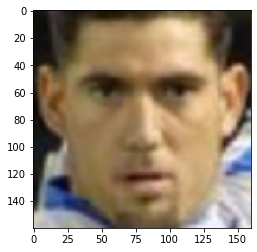

Patsy_Kensit


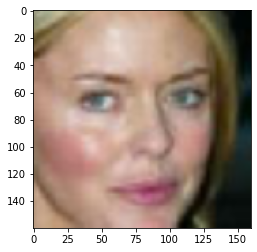

In [ ]:
for i in range (0,2):
    image = x_batch_train[i]
    #print(image.shape)
    #print(np.argmax(y_batch[i]))
    #print(np.argmax(y_batch_train[i]))
    print(labels[np.argmax(y_batch_train[i])])
    plt.imshow(image)
    plt.show()

In [ ]:
net = load_model('/content/drive/MyDrive/facenet_keras.h5')
#net.summary()

In [ ]:
def triplet_loss(y_true, y_pred, alpha = 0.3):    
  anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]    
  pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,positive)), axis=-1)
  neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)), axis=-1)
  basic_loss = tf.add(tf.subtract(pos_dist, neg_dist), alpha)
  loss = tf.reduce_sum(tf.maximum(basic_loss, 0.0))
  return loss

In [ ]:
net.compile(optimizer = 'adam', loss = triplet_loss, metrics = ['accuracy'])

In [ ]:
def extract_embeddings(model,face_pixels):
  face_pixels = face_pixels.astype('float32')  
  mean = face_pixels.mean()                    
  std  = face_pixels.std()                     
  face_pixels = (face_pixels - mean)/std       
  samples = np.expand_dims(face_pixels,axis=0)     
  yhat = model.predict(samples)
  return yhat[0]

In [ ]:
train_image_embeddings = []
for image in x_batch_train:
  train_image_embeddings.append(extract_embeddings(net, image))
train_image_embeddings = np.asarray(train_image_embeddings)
#print(train_image_embeddings.shape)

test_image_embeddings = []
for image in x_batch_test:
  test_image_embeddings.append(extract_embeddings(net, image))
test_image_embeddings = np.asarray(test_image_embeddings)
#print(test_image_embeddings.shape)

In [ ]:
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(train_image_embeddings)
testX = in_encoder.transform(test_image_embeddings)

y_train = np.argmax(y_batch_train, axis=1)
y_test = np.argmax(y_batch_test, axis=1)

In [ ]:
net = SVC(kernel='linear', probability=True)
net.fit(trainX, y_train)

SVC(kernel='linear', probability=True)

In [ ]:
yhat_train = net.predict(trainX)
yhat_test = net.predict(testX)
#print(yhat_train)

In [ ]:
score_train = accuracy_score(y_train, yhat_train)
score_test = accuracy_score(y_test, yhat_test)
print('Dataset: train = %d, test = %d' % (trainX.shape[0], testX.shape[0]))
print('Accuracy: train = %.3f, test = %.3f' % (score_train*100, score_test*100))

Dataset: train = 12161, test = 1072
Accuracy: train = 63.366, test = 96.175
